In [1]:
import scipy
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt


In [3]:
%run "../../functions/get_data.ipynb"
%run "../../functions/bandpass.ipynb"
%run "../../functions/trimmer.ipynb"

# DATA PREPROCESSING

In [4]:
folder_path = "../../data/swd_data/walk_inst_raw/"
old_folder_path = "../../data/initial_data/walk_inst_raw/"

In [5]:
file_list = get_file_list(folder_path)
old_file_list = get_file_list(old_folder_path)

print(file_list)
print(old_file_list)

['../../data/swd_data/walk_inst_raw/P_1.mat', '../../data/swd_data/walk_inst_raw/P_10.mat', '../../data/swd_data/walk_inst_raw/P_2.mat', '../../data/swd_data/walk_inst_raw/P_3.mat', '../../data/swd_data/walk_inst_raw/P_4.mat', '../../data/swd_data/walk_inst_raw/P_5.mat', '../../data/swd_data/walk_inst_raw/P_9.mat', '../../data/swd_data/walk_inst_raw/S_1.mat', '../../data/swd_data/walk_inst_raw/S_10.mat', '../../data/swd_data/walk_inst_raw/S_2.mat', '../../data/swd_data/walk_inst_raw/S_3.mat', '../../data/swd_data/walk_inst_raw/S_4.mat', '../../data/swd_data/walk_inst_raw/S_5.mat', '../../data/swd_data/walk_inst_raw/S_9.mat']
['../../data/initial_data/walk_inst_raw/P_1.mat', '../../data/initial_data/walk_inst_raw/P_10.mat', '../../data/initial_data/walk_inst_raw/P_2.mat', '../../data/initial_data/walk_inst_raw/P_3.mat', '../../data/initial_data/walk_inst_raw/P_4.mat', '../../data/initial_data/walk_inst_raw/P_5.mat', '../../data/initial_data/walk_inst_raw/P_9.mat', '../../data/initial_da

In [6]:
X = []

removed_trials = 0
initial_trials = 0

for i, file in enumerate(file_list):
    x = scipy.io.loadmat(file)
    x = x['file_swds']

    old_x = scipy.io.loadmat(old_file_list[i])
    old_x = old_x['data']
    initial_trials += old_x.shape[0]

    if(x.shape[0] > 0):

        print(f"{old_x.shape[0]} trials => {x.shape[1]} trials")

        removed_trials = removed_trials + old_x.shape[0] - x.shape[1]
        
        data = np.array([ m[0] for m in x[0] ])
        
        first_letter = file.split('/')[-1][0]

        if first_letter == 'P':
                y = np.zeros((x.shape[0],2))
                y[:,0] = 1
        else:
            y = np.zeros((x.shape[0],2))
            y[:,1] = 1  

        X.append(data)

    else:
        print(f"{old_x.shape[0]} trials => 0 trials")
        removed_trials += old_x.shape[0]

print(f"Total trials removed: {removed_trials} out of {initial_trials}")



56 trials => 1 trials
37 trials => 26 trials
49 trials => 0 trials
56 trials => 51 trials
58 trials => 25 trials
57 trials => 26 trials
60 trials => 50 trials
60 trials => 25 trials
67 trials => 33 trials
60 trials => 26 trials
80 trials => 50 trials
79 trials => 16 trials
66 trials => 46 trials
84 trials => 60 trials
Total trials removed: 434 out of 869


In [7]:
input_data = []
for x in X:
    data = []
    for i, trial in enumerate(x):
        trial_data = []
        for j, channel in enumerate(trial):
            channel_data = []
            for k, ocm in enumerate(channel):
                ocm_data = []
                for l, sample in enumerate(ocm):
                    ocm_data.append(sample)
                channel_data.append(ocm_data)
            trial_data.append(channel_data)
        data.append(trial_data)

    data = np.array(data)
    input_data.append(data)


# reshape the data in accordance to the input shape of the model
for i, data in enumerate(input_data):
    input_data[i] = np.reshape(data, (data.shape[0], data.shape[1], data.shape[3], data.shape[2]))

In [8]:
for data in input_data:
    print(data.shape)

(1, 11, 250, 3)
(26, 11, 250, 3)
(51, 11, 250, 3)
(25, 11, 250, 3)
(26, 11, 250, 3)
(50, 11, 250, 3)
(25, 11, 250, 3)
(33, 11, 250, 3)
(26, 11, 250, 3)
(50, 11, 250, 3)
(16, 11, 250, 3)
(46, 11, 250, 3)
(60, 11, 250, 3)


In [9]:
Y = []
for i, data in enumerate(input_data):
    if i < 6:
        Y.extend([0] * len(data))
    else:
        Y.extend([1] * len(data))

Y = np.array(Y)
X = np.concatenate(input_data, axis=0)
print(Y.shape, X.shape)


(435,) (435, 11, 250, 3)


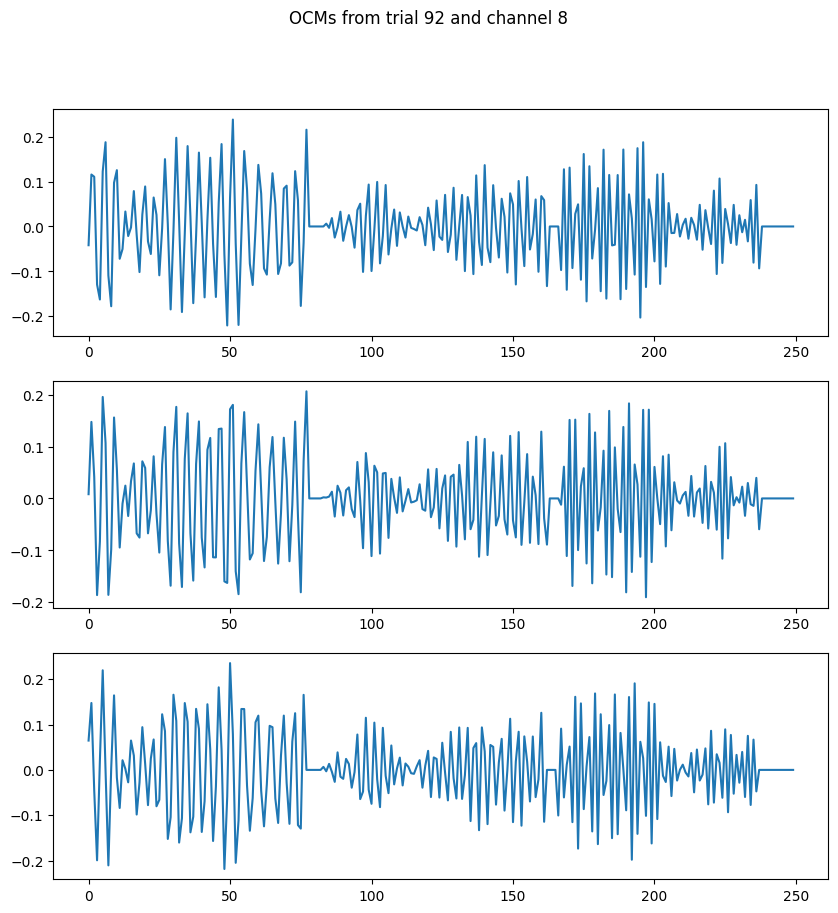

In [10]:
# plot the 3 OCMs from one random channel

channel = np.random.randint(0, X.shape[1])
trial = np.random.randint(0, X.shape[0])

plt.subplots(nrows=3, ncols=1, figsize=(10,10))
plt.suptitle(f"OCMs from trial {trial} and channel {channel}")
plt.subplot(3,1,1)
plt.plot(X[trial, channel, :, 0])
plt.subplot(3,1,2)
plt.plot(X[trial, channel, :, 1])
plt.subplot(3,1,3)
plt.plot(X[trial, channel, :, 2])
plt.show()



# DEFINING, COMPILING AND TRAINING THE MODEL

In [ ]:
best_acc = 0
best_model = None

accuracies = []

num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

# model.summary()

for train_index,val_index in kfold.split(X):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(30, (8,8), activation='relu', input_shape=(11, 250, 3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    # Get the training and validation data for this fold
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    
    # Train the model
    model.fit(X_train, Y_train, epochs=50, batch_size=32)

    # Evaluate the model on the validation data for this fold using the balanced accuracy
    y_pred = model.predict(X_val)
    y_pred = np.round(y_pred)
    acc = balanced_accuracy_score(Y_val, y_pred)

    accuracies.append(acc)
    
    if(acc > best_acc):
        best_acc = acc
        best_model = model
    

    # # Evaluate the model on the validation data for this fold
    # model.evaluate(X_val_fold, Y_val_fold)



### Evaluate the model on the test data

In [12]:
print(f"Best model accuracy: {best_acc}")

print(f"Average accuracy: {np.mean(accuracies)}")

Best model accuracy: 0.7864923747276689
Average accuracy: 0.7864923747276689
